Zero shot and n shot 

In [1]:
pip install transformers pandas torch


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from transformers import pipeline, GPT2Tokenizer, GPT2LMHeadModel
import torch
from torch.optim import AdamW

# Load the cleaned dataset
data = pd.read_csv('labeled_comments_cleaned.csv')

# Check the columns in the DataFrame
print("Columns in the dataset:", data.columns)

# Use 'comment_full_text' as the comments column
comments_column = 'comment_full_text'
comments = data[comments_column].tolist()

# Initialize the zero-shot classification pipeline
zero_shot_classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli')

# Define candidate labels for zero-shot learning
candidate_labels = ["urgent", "important", "general", "irrelevant"]

# Function to apply zero-shot classification in batches
def batch_zero_shot_classification(comments, batch_size=50):
    results = []
    for i in range(0, len(comments), batch_size):
        batch = comments[i:i+batch_size]
        batch_results = zero_shot_classifier(batch, candidate_labels)
        results.extend(batch_results)
        print(f"Processed batch {i//batch_size + 1}/{len(comments)//batch_size + 1}")
    return results

# Apply zero-shot classification in batches
print("Applying zero-shot classification...")
zero_shot_results = batch_zero_shot_classification(comments)

# Add results to the dataframe
data['zero_shot_labels'] = [result['labels'][0] for result in zero_shot_results]

# Display the updated dataframe
print(data.head())

# Save the results to a new CSV
data.to_csv('labeled_comments_with_zero_shot.csv', index=False)

# For n-shot learning, we'll fine-tune a model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Add padding token
tokenizer.pad_token = tokenizer.eos_token

# Fine-tuning on a small number of examples (n-shot learning)
def fine_tune_model(comments, model, tokenizer, epochs=1):
    optimizer = AdamW(model.parameters(), lr=5e-5)
    model.train()
    for epoch in range(epochs):
        for i, comment in enumerate(comments):
            inputs = tokenizer(comment, return_tensors='pt', padding=True, truncation=True)
            inputs['labels'] = inputs.input_ids
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if i % 10 == 0:
                print(f'Epoch {epoch + 1}, Step {i + 1}, Loss: {loss.item()}')

# Example fine-tuning with 5-shot learning
n_shot_examples = 5
fine_tune_model(comments[:n_shot_examples], model, tokenizer, epochs=1)

# Save the fine-tuned model
model.save_pretrained('./fine_tuned_gpt2')
tokenizer.save_pretrained('./fine_tuned_gpt2')

# Use the fine-tuned model for predictions
fine_tuned_pipeline = pipeline('text-generation', model='./fine_tuned_gpt2', tokenizer=tokenizer)

print("Generating n-shot predictions...")
n_shot_results = [fine_tuned_pipeline(comment, max_new_tokens=50)[0]['generated_text'] for comment in comments]

# Add n-shot results to the dataframe
data['n_shot_labels'] = n_shot_results

# Display the updated dataframe
print(data.head())

# Save the results to a new CSV
data.to_csv('labeled_comments_with_n_shot.csv', index=False)


Columns in the dataset: Index(['file_id', 'comment_id', 'comment_date', 'anonymized_nickname',
       'document_paragraph_text', 'document_selected_text',
       'document_selected_sentences', 'comment_full_text',
       'comment_sentence_text', 'is_sentence', 'num_sentence',
       'total_sentences', 'grammar_checked', 'grammatical_errors',
       'has_replies', 'is_reply', 'num_reply', 'num_replies', 'is_resolved',
       'language_name', 'num_hyperlinks', 'num_images', 'spelling_checked',
       'spelling_errors', 'tracked_changes', 'next_action', 'level_0',
       'level_1', 'level_2', 'level_3', 'level_4', 'date_column',
       'time_column'],
      dtype='object')
Applying zero-shot classification...
Processed batch 1/100
Processed batch 2/100
Processed batch 3/100
Processed batch 4/100
Processed batch 5/100
Processed batch 6/100
Processed batch 7/100
Processed batch 8/100
Processed batch 9/100
Processed batch 10/100
Processed batch 11/100
Processed batch 12/100
Processed batch 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Let's start by loading the CSV file that contains our zero-shot labels.
data = pd.read_csv('labeled_comments_with_zero_shot.csv')



In [3]:

# Take a quick look at the first few rows of the data to get a sense of what's inside.
print(data.head())



                                file_id                            comment_id  \
0  ed88fa24-1a89-44fb-9a66-c7f554d87f5d  ffc97358-69e6-48fb-aaf0-6a844e26f653   
1  0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e  ffa706dc-4877-492d-ac74-598d5f4d07c5   
2  0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e  ffa706dc-4877-492d-ac74-598d5f4d07c5   
3  0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e  ffa706dc-4877-492d-ac74-598d5f4d07c5   
4  f5208894-9572-4cb8-b023-00b3c03cee89  ff533813-4050-424d-8e01-3c8dbb392f4d   

                               comment_date       anonymized_nickname  \
0  2013-04-09 09:30:00+00:00 00:00:00+00:00                    Editor   
1  2011-12-08 15:51:00+00:00 00:00:00+00:00  Alicia R. Dalton-Tingler   
2  2011-12-08 15:51:00+00:00 00:00:00+00:00  Alicia R. Dalton-Tingler   
3  2011-12-08 15:51:00+00:00 00:00:00+00:00  Alicia R. Dalton-Tingler   
4  2016-03-09 15:05:00+00:00 00:00:00+00:00            Alannah Kittle   

                             document_paragraph_text document_selected_tex

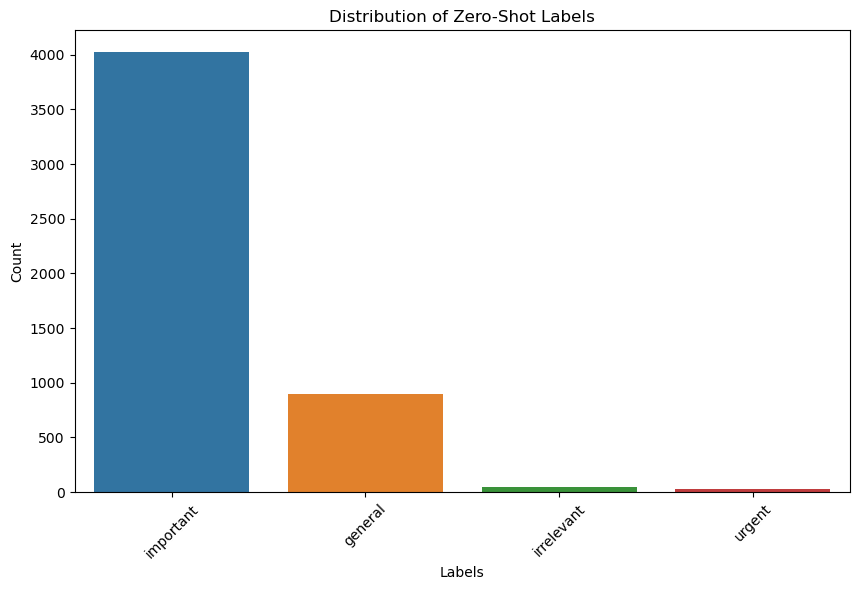

In [4]:
# Step 2: Visualize the Distribution of Zero-Shot Labels
# We'll create a bar chart to see how the model distributed the comments across the different labels.
plt.figure(figsize=(10, 6))
sns.countplot(x='zero_shot_labels', data=data, order=data['zero_shot_labels'].value_counts().index)
plt.title('Distribution of Zero-Shot Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


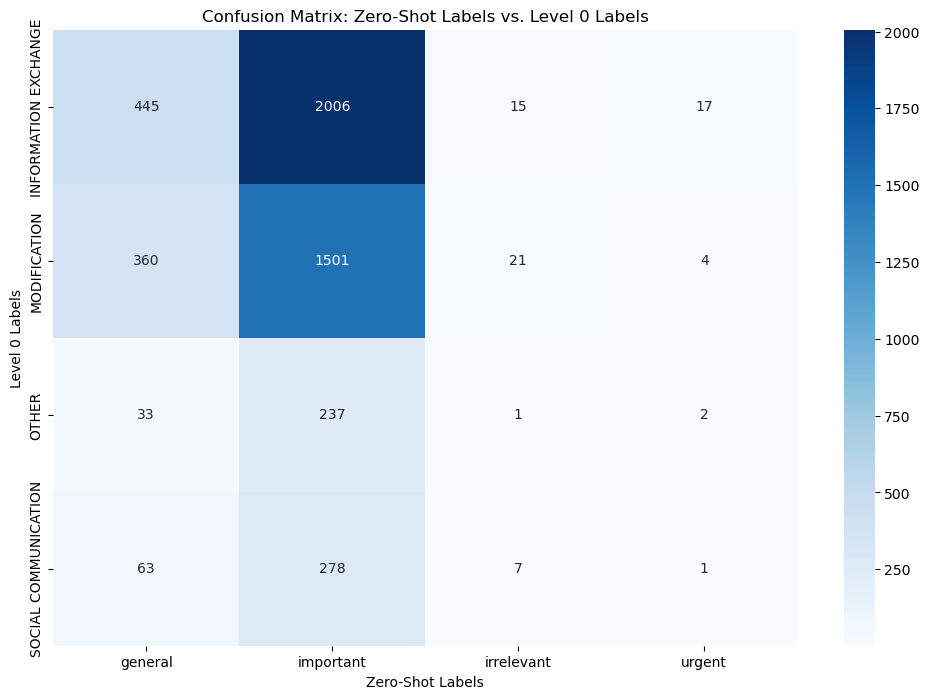

In [5]:

# Step 3: Analyze the Relationship Between Zero-Shot Labels and Original Labels (Level 0)
# Now, let's dig a bit deeper. We'll compare the zero-shot labels with the original Level 0 labels using a confusion matrix.
# This will help us understand where the model's predictions align with the original labels and where they differ.
confusion_matrix = pd.crosstab(data['level_0'], data['zero_shot_labels'])

plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Zero-Shot Labels vs. Level 0 Labels')
plt.xlabel('Zero-Shot Labels')
plt.ylabel('Level 0 Labels')
plt.show()


In [6]:

# Step 4: Explore Data by Label
# Let's take a closer look at some actual comments. We'll sample a few examples from each zero-shot label to see how the model categorized them.
for label in data['zero_shot_labels'].unique():
    print(f"\nExamples of comments classified as '{label}':")
    examples = data[data['zero_shot_labels'] == label]['comment_full_text'].sample(5, random_state=42).tolist()
    for i, comment in enumerate(examples, 1):
        print(f"{i}. {comment}")



Examples of comments classified as 'important':
1. As of 1 October 2015, expedited (individual) SAE reports has to be reported through the webportal ToetsingOnline. This is not mandatory for SUSAR reports. See also chapter 9.2.3.  Instructions for this can be found in the user manual, see https://toetsingonline.nl/
2. Qualitative response code
3. If core/bore report is available, insert blank page and copy of report and renumber pages that follow accordingly.  Also update indexes and table of contents.
4. was Taketo
5. Obtain from the EGI document server: documents.egi.eu

Examples of comments classified as 'general':
1. A coordinating investigator is an investigator who bears the responsibility for the coordination of investigators operating in the various centers participating in multicentre research. Not all multicentre research will have a coordinating investigator. There is no requirement to appoint one.
A project leader has the responsibility to develop a research protocol and t

In [7]:



# Step 5: Summarize Insights
# Finally, let's summarize what we've learned from these visualizations and analyses.
print("\nSummary of Insights:")
print("1. The distribution of zero-shot labels gives us a sense of how the model is categorizing the comments. We might notice some classes are more frequent than others.")
print("2. The confusion matrix helps us see how well the zero-shot labels match the original Level 0 labels. This can highlight areas where the model performs well or where it might need improvement.")
print("3. By looking at specific examples, we can better understand how the model is making its decisions. This is crucial for interpreting the results and refining the model.")





Summary of Insights:
1. The distribution of zero-shot labels gives us a sense of how the model is categorizing the comments. We might notice some classes are more frequent than others.
2. The confusion matrix helps us see how well the zero-shot labels match the original Level 0 labels. This can highlight areas where the model performs well or where it might need improvement.
3. By looking at specific examples, we can better understand how the model is making its decisions. This is crucial for interpreting the results and refining the model.


In [8]:

plt.savefig('distribution_of_zero_shot_labels.png')
plt.savefig('confusion_matrix_zero_shot_vs_level_0.png')

<Figure size 640x480 with 0 Axes>

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [14]:
# Let's start by loading the CSV file that contains our zero-shot labels.
data = pd.read_csv('labeled_comments_with_n_shot.csv')



In [15]:

# Take a quick look at the first few rows of the data to get a sense of what's inside.
print(data.head())



                                file_id                            comment_id  \
0  ed88fa24-1a89-44fb-9a66-c7f554d87f5d  ffc97358-69e6-48fb-aaf0-6a844e26f653   
1  0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e  ffa706dc-4877-492d-ac74-598d5f4d07c5   
2  0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e  ffa706dc-4877-492d-ac74-598d5f4d07c5   
3  0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e  ffa706dc-4877-492d-ac74-598d5f4d07c5   
4  f5208894-9572-4cb8-b023-00b3c03cee89  ff533813-4050-424d-8e01-3c8dbb392f4d   

                               comment_date       anonymized_nickname  \
0  2013-04-09 09:30:00+00:00 00:00:00+00:00                    Editor   
1  2011-12-08 15:51:00+00:00 00:00:00+00:00  Alicia R. Dalton-Tingler   
2  2011-12-08 15:51:00+00:00 00:00:00+00:00  Alicia R. Dalton-Tingler   
3  2011-12-08 15:51:00+00:00 00:00:00+00:00  Alicia R. Dalton-Tingler   
4  2016-03-09 15:05:00+00:00 00:00:00+00:00            Alannah Kittle   

                             document_paragraph_text document_selected_tex

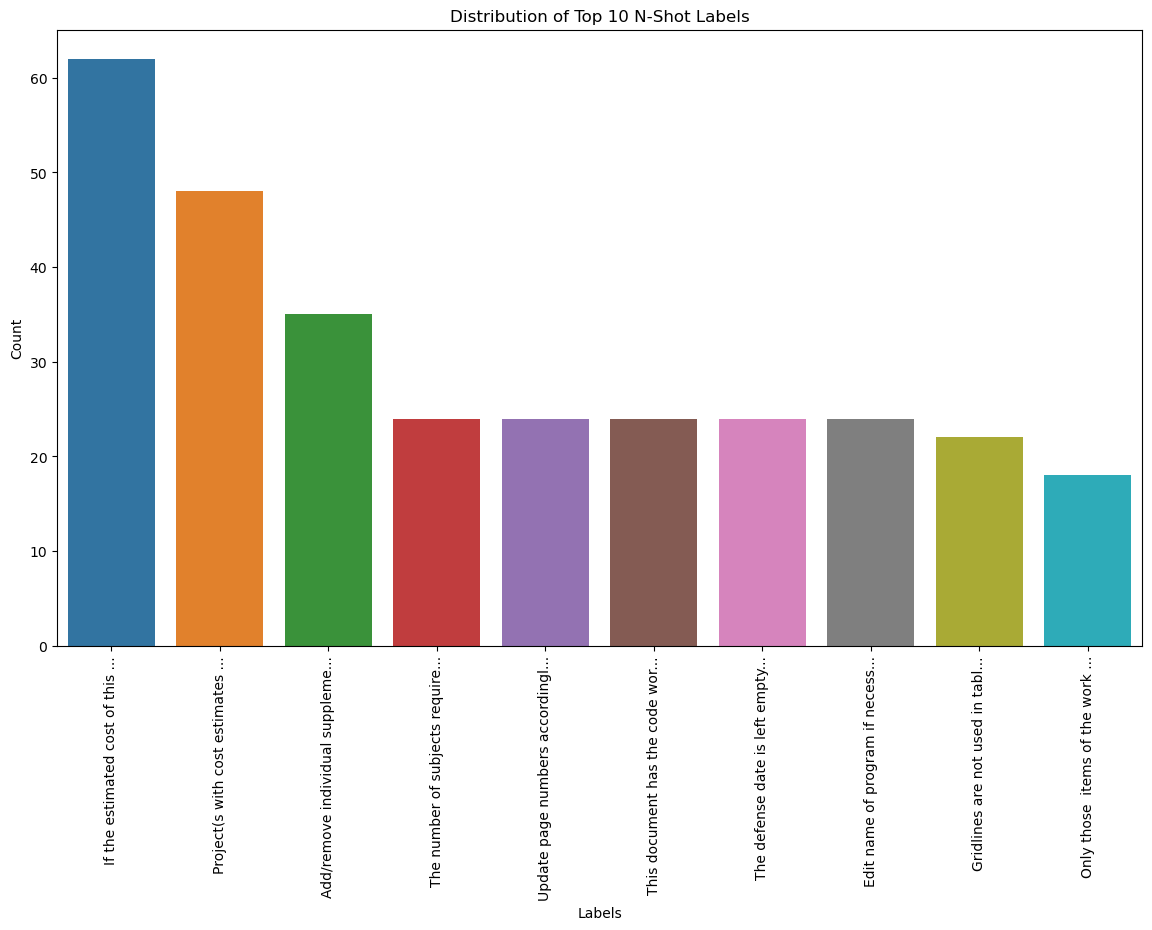

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset with N-shot labels
data = pd.read_csv('labeled_comments_with_n_shot.csv')

# Truncate labels for better readability
data['truncated_n_shot_labels'] = data['n_shot_labels'].apply(lambda x: (x[:30] + '...') if len(x) > 30 else x)

# Visualize the Distribution of N-Shot Labels (limited to top 10 labels for clarity)
plt.figure(figsize=(14, 8))
top_labels = data['truncated_n_shot_labels'].value_counts().nlargest(10).index
sns.countplot(x='truncated_n_shot_labels', data=data[data['truncated_n_shot_labels'].isin(top_labels)], order=top_labels)
plt.title('Distribution of Top 10 N-Shot Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels to 90 degrees for better readability
plt.show()


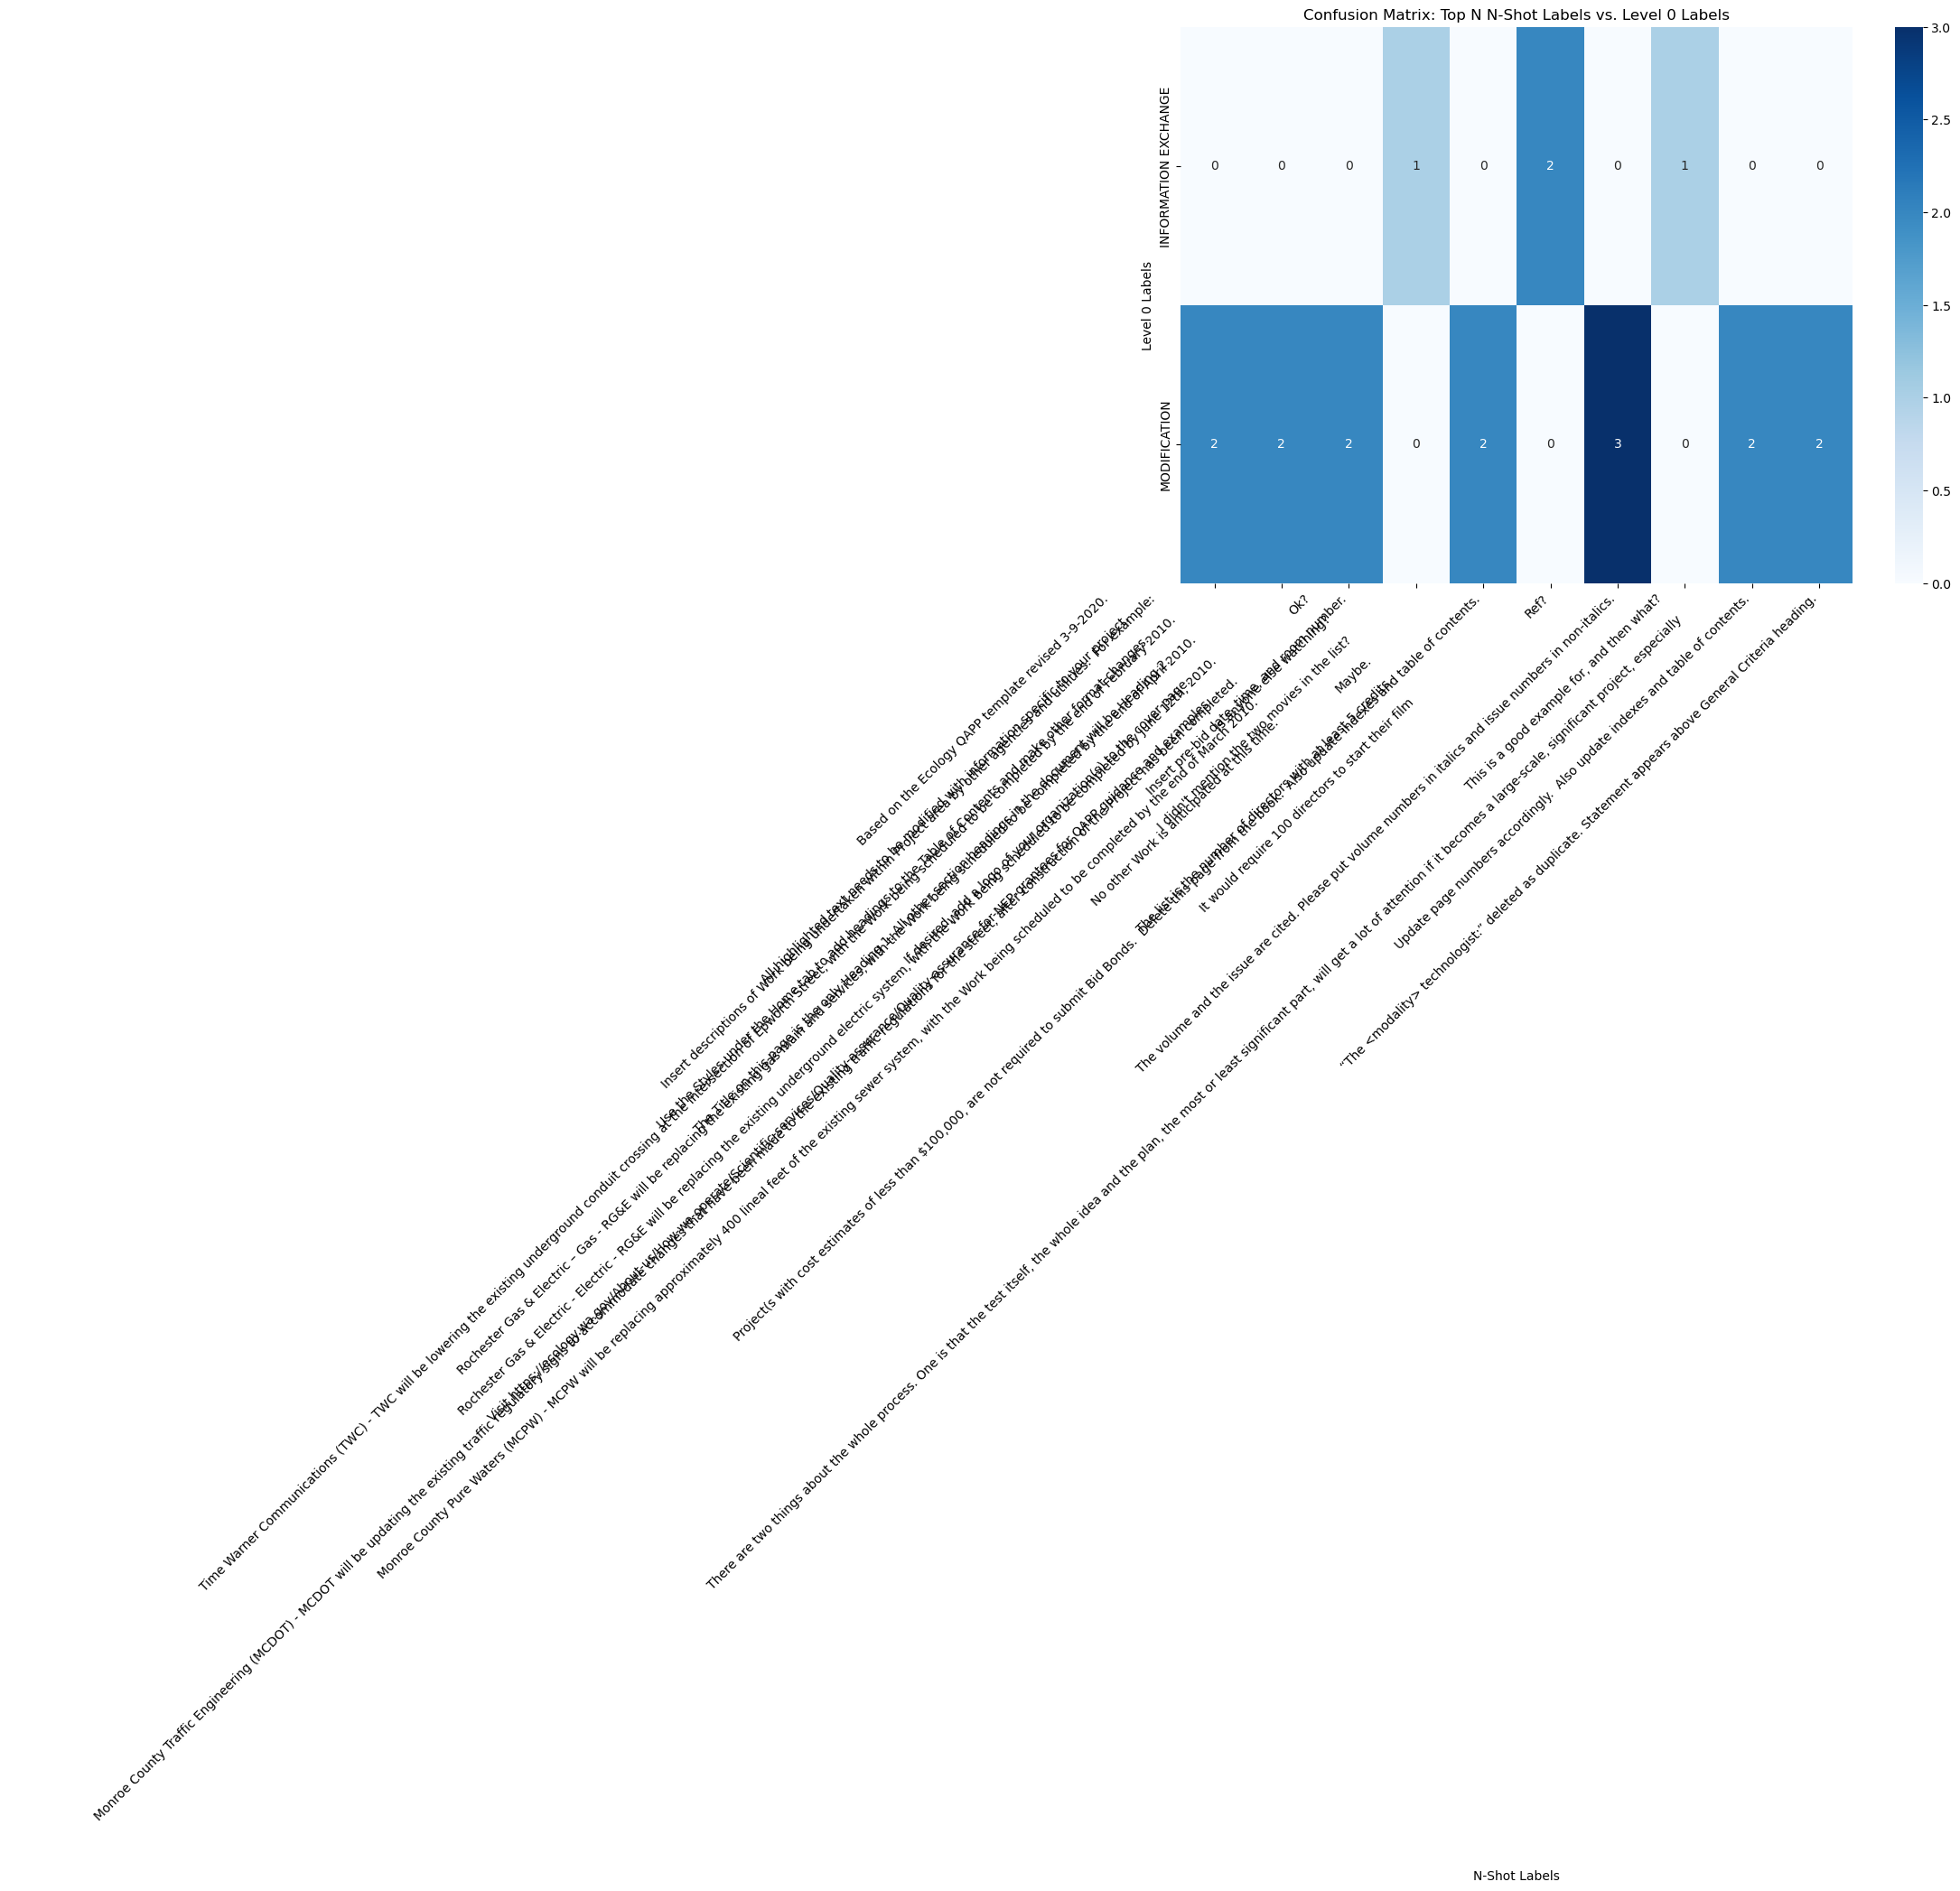

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset with N-shot labels
data = pd.read_csv('labeled_comments_with_n_shot.csv')

# Get the top N most frequent N-shot labels
top_n_labels = data['n_shot_labels'].value_counts().index[:10]

# Filter the data to include only these top N labels
filtered_data = data[data['n_shot_labels'].isin(top_n_labels)]

# Create a confusion matrix comparing the original Level 0 labels with the filtered N-shot labels
confusion_matrix = pd.crosstab(filtered_data['level_0'], filtered_data['n_shot_labels'])

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Top N N-Shot Labels vs. Level 0 Labels')
plt.xlabel('N-Shot Labels')
plt.ylabel('Level 0 Labels')
plt.xticks(rotation=45, ha='right')
plt.show()


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

# Load the dataset
data = pd.read_csv('labeled_comments_with_n_shot.csv')

# Step 1: Categorize/Cluster the n_shot_labels using TF-IDF and KMeans
def cluster_n_shot_labels(n_shot_labels, num_clusters=10):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(n_shot_labels)
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)
    
    return clusters



/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


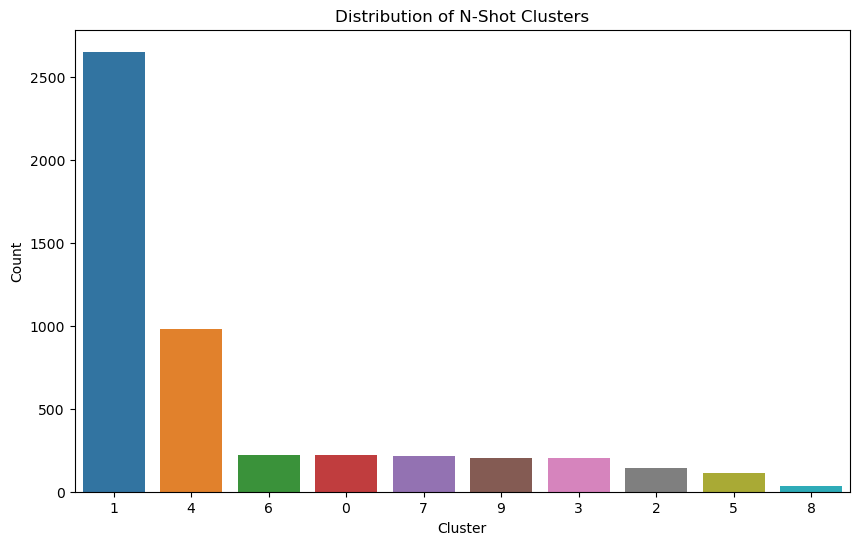

In [32]:
# Apply clustering to the n_shot_labels
data['n_shot_cluster'] = cluster_n_shot_labels(data['n_shot_labels'], num_clusters=10)

# Step 2: Visualize the distribution of clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='n_shot_cluster', data=data, order=data['n_shot_cluster'].value_counts().index)
plt.title('Distribution of N-Shot Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()



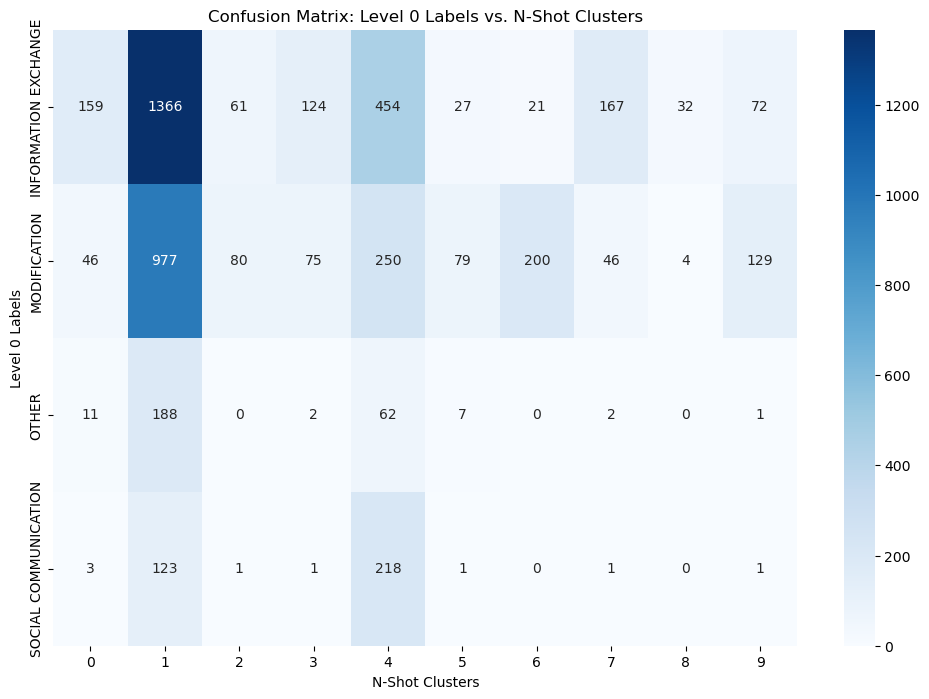

In [33]:
# Step 3: Generate a confusion matrix with Level 0 labels vs. N-Shot Clusters
conf_matrix = pd.crosstab(data['level_0'], data['n_shot_cluster'])

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Level 0 Labels vs. N-Shot Clusters')
plt.xlabel('N-Shot Clusters')
plt.ylabel('Level 0 Labels')
plt.show()



In [34]:


# Step 4: Subset the data to focus on the top N most frequent labels if needed
top_n = 10
top_n_labels = data['n_shot_cluster'].value_counts().index[:top_n]
filtered_data = data[data['n_shot_cluster'].isin(top_n_labels)]


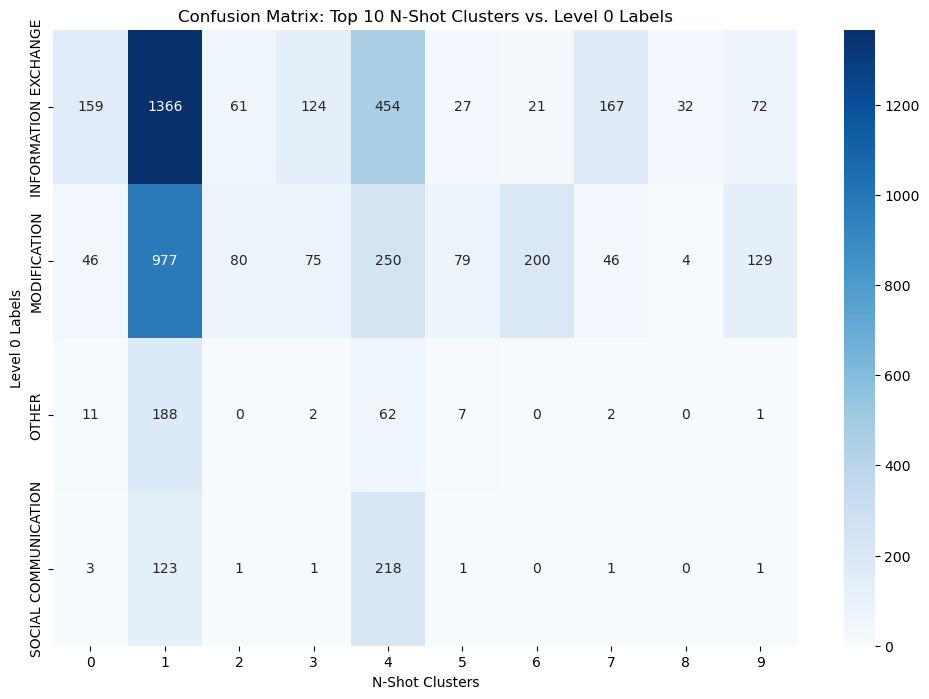

In [36]:


# Generate a confusion matrix for the top N labels
conf_matrix_top_n = pd.crosstab(filtered_data['level_0'], filtered_data['n_shot_cluster'])

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_top_n, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: Top {top_n} N-Shot Clusters vs. Level 0 Labels')
plt.xlabel('N-Shot Clusters')
plt.ylabel('Level 0 Labels')
plt.show()


In [39]:
# Display the columns in the DataFrame
print(data.columns)


Index(['file_id', 'comment_id', 'comment_date', 'anonymized_nickname',
       'document_paragraph_text', 'document_selected_text',
       'document_selected_sentences', 'comment_full_text',
       'comment_sentence_text', 'is_sentence', 'num_sentence',
       'total_sentences', 'grammar_checked', 'grammatical_errors',
       'has_replies', 'is_reply', 'num_reply', 'num_replies', 'is_resolved',
       'language_name', 'num_hyperlinks', 'num_images', 'spelling_checked',
       'spelling_errors', 'tracked_changes', 'next_action', 'level_0',
       'level_1', 'level_2', 'level_3', 'level_4', 'date_column',
       'time_column', 'zero_shot_labels', 'n_shot_labels'],
      dtype='object')


In [40]:
from sklearn.cluster import KMeans
import pandas as pd

# Assuming 'n_shot_labels' needs to be clustered
# Let's convert text labels to numeric data using a simple count-based vectorizer for clustering
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Transform the 'n_shot_labels' into a matrix of token counts
X = vectorizer.fit_transform(data['n_shot_labels'])

# Perform KMeans clustering with a number of clusters (k) that makes sense (e.g., 10 clusters)
kmeans = KMeans(n_clusters=10, random_state=42)
data['cluster'] = kmeans.fit_predict(X)

# Now, let's check the DataFrame with the new 'cluster' column
print(data.head())

# Now you can use the cluster labels to examine specific clusters
def display_cluster_samples(data, cluster_label, sample_size=5):
    print(f"\nExamples of comments in Cluster {cluster_label}:")
    cluster_comments = data[data['cluster'] == cluster_label]['comment_full_text']
    if len(cluster_comments) > sample_size:
        examples = cluster_comments.sample(sample_size, random_state=42).tolist()
    else:
        examples = cluster_comments.tolist()
    for i, comment in enumerate(examples, 1):
        print(f"{i}. {comment[:500]}")  # Display the first 500 characters to avoid long output

# Analyze Cluster 1 (the largest cluster)
display_cluster_samples(data, cluster_label=1)

# Analyze another smaller cluster (let's choose Cluster 4 for this example)
display_cluster_samples(data, cluster_label=4)


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                                file_id                            comment_id  \
0  ed88fa24-1a89-44fb-9a66-c7f554d87f5d  ffc97358-69e6-48fb-aaf0-6a844e26f653   
1  0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e  ffa706dc-4877-492d-ac74-598d5f4d07c5   
2  0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e  ffa706dc-4877-492d-ac74-598d5f4d07c5   
3  0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e  ffa706dc-4877-492d-ac74-598d5f4d07c5   
4  f5208894-9572-4cb8-b023-00b3c03cee89  ff533813-4050-424d-8e01-3c8dbb392f4d   

                               comment_date       anonymized_nickname  \
0  2013-04-09 09:30:00+00:00 00:00:00+00:00                    Editor   
1  2011-12-08 15:51:00+00:00 00:00:00+00:00  Alicia R. Dalton-Tingler   
2  2011-12-08 15:51:00+00:00 00:00:00+00:00  Alicia R. Dalton-Tingler   
3  2011-12-08 15:51:00+00:00 00:00:00+00:00  Alicia R. Dalton-Tingler   
4  2016-03-09 15:05:00+00:00 00:00:00+00:00            Alannah Kittle   

                             document_paragraph_text document_selected_tex

In [41]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords
import nltk
from pprint import pprint

# Ensure you have the necessary NLTK data files
nltk.download('stopwords')

# Step 1: Load Data
data = pd.read_csv('labeled_comments_with_n_shot.csv')

# Step 2: Preprocessing
# Tokenize, remove stopwords, and preprocess
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = gensim.utils.simple_preprocess(text)
    return [token for token in tokens if token not in stop_words]

# Apply preprocessing to the comments
data['processed_text'] = data['comment_full_text'].apply(preprocess)

# Step 3: Create a dictionary and corpus
dictionary = corpora.Dictionary(data['processed_text'])
corpus = [dictionary.doc2bow(text) for text in data['processed_text']]

# Step 4: Train LDA Model
# Set the number of topics (e.g., 5) based on your dataset
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Step 5: Interpret the topics
pprint(lda_model.print_topics())

# Step 6: Assign topics to documents
# Get the dominant topic for each document
data['dominant_topic'] = [max(lda_model[corpus[i]], key=lambda x: x[1])[0] for i in range(len(corpus))]

# Save the result with assigned topics
data.to_csv('labeled_comments_with_lda_topics.csv', index=False)


[nltk_data] Downloading package stopwords to /home/spati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[(0,
  '0.021*"page" + 0.017*"table" + 0.014*"project" + 0.014*"also" + '
  '0.013*"update" + 0.010*"bonds" + 0.010*"contents" + 0.010*"requirements" + '
  '0.010*"subsection" + 0.010*"following"'),
 (1,
  '0.011*"mtg" + 0.010*"one" + 0.009*"line" + 0.009*"table" + '
  '0.009*"committees" + 0.009*"name" + 0.009*"mw" + 0.008*"please" + '
  '0.008*"work" + 0.008*"program"'),
 (2,
  '0.017*"study" + 0.009*"research" + 0.008*"information" + 0.007*"data" + '
  '0.007*"subjects" + 0.007*"non" + 0.007*"also" + 0.007*"section" + '
  '0.006*"link" + 0.006*"include"'),
 (3,
  '0.008*"government" + 0.008*"section" + 0.007*"pfhxs" + 0.007*"paragraph" + '
  '0.006*"inserted" + 0.006*"state" + 0.006*"sentence" + 0.006*"health" + '
  '0.005*"need" + 0.005*"document"'),
 (4,
  '0.013*"read" + 0.012*"across" + 0.012*"may" + 0.011*"information" + '
  '0.010*"pfbs" + 0.010*"pfos" + 0.010*"data" + 0.009*"would" + '
  '0.009*"effects" + 0.008*"similar"')]


### Understanding the Analysis Process:

#### **1. Clustering: Grouping Similar Comments Together**

**Why Clustering Was Used:**
I used clustering to help make sense of an extensive collection of comments by grouping them into categories based on their similarities. The idea was to identify natural groupings or patterns within the data without pre-defining any specific categories. By doing this, we can see which comments are talking about similar things, which makes it easier to understand the main topics people are discussing.

**What the Clustering Showed:**
- **Main Themes:** The clustering process suggested that many comments might be focused on general operational details, like instructions, guidelines, and project updates. This could mean that much of the dataset's discussion revolves around everyday administrative tasks.
- **Specialized Topics:** Small clusters also focused on more specific topics, such as legal or contractual details or technical information related to research. This implies that while broad, general discussions are happening, there are also niche areas of focus that could be important to different people or departments.

#### **2. LDA: Digging Deeper into the Topics**

**Why LDA Was Used:**
After grouping the comments, I wanted to understand the specific topics people were discussing within these groups. LDA (Latent et al.) is a method that helps identify the main topics in a collection of documents by looking at the words that frequently appear together. By using LDA, I could see what specific themes were present in the comments and how they were distributed across the different clusters.

**What the LDA Analysis Suggested:**
- **Detailed Topics:** The LDA analysis identified several critical topics represented by keywords. For example, one topic was project updates and requirements, while another focused on research and study-related details. This gave a more detailed view of what people were discussing.
- **Sub-Themes:** LDA seemed to reveal sub-themes Within the broader clusters identified earlier. For instance, a general administrative cluster might have sub-topics like meeting schedules, project timelines, or specific sections of documents. This helped me understand the main themes and the finer details of what was being discussed.
- **Guiding Future Analysis:** These insights from LDA could guide further analysis or decision-making. For example, if many comments are focused on legal or regulatory issues, it might suggest that these are critical areas that need more attention. Similarly, topics related to research could indicate essential areas that might require deeper investigation.

### **In Summary:**
By combining clustering and LDA, I was able to get a clearer picture of what the dataset is about. Clustering helped me see the main groups of comments, showing me what the general discussions might be. LDA then allowed me to dive deeper into these groups, revealing specific topics and sub-topics that people are talking about.

So, according to my analysis, this approach simplified a complex dataset into more understandable themes and provided insights into specific areas of interest. This could help make more informed decisions, focus on critical areas, and better understand the overall conversation happening in the dataset.

In [44]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import nltk

# Ensure the necessary NLTK resources are available
nltk.download('stopwords')

# Load dataset
data = pd.read_csv('labeled_comments_with_n_shot.csv')

# Define stopwords
stop_words = stopwords.words('english')

# Function to preprocess each comment
def preprocess(comment):
    return [word for word in simple_preprocess(comment) if word not in stop_words]

# Apply preprocessing to each comment in the 'comment_full_text' column
texts = data['comment_full_text'].apply(preprocess).tolist()


[nltk_data] Downloading package stopwords to /home/spati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


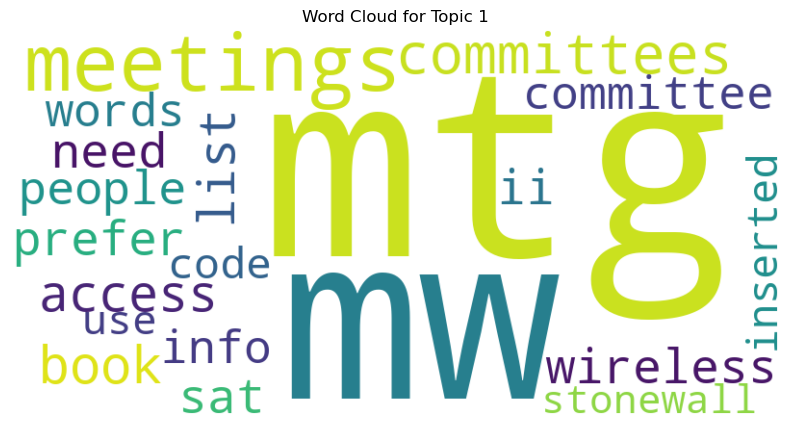

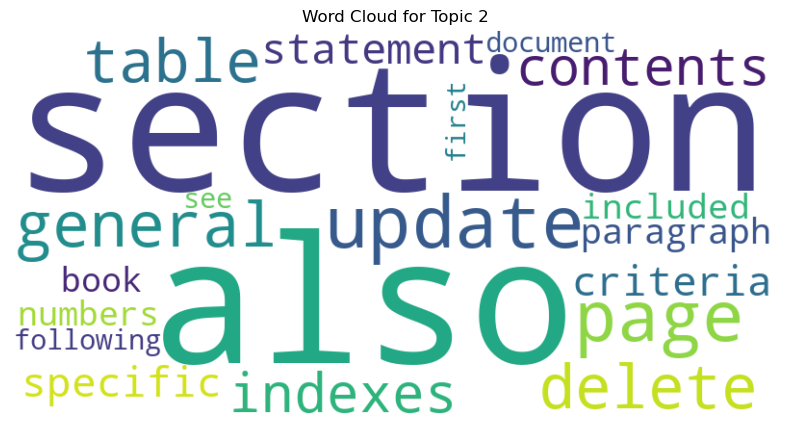

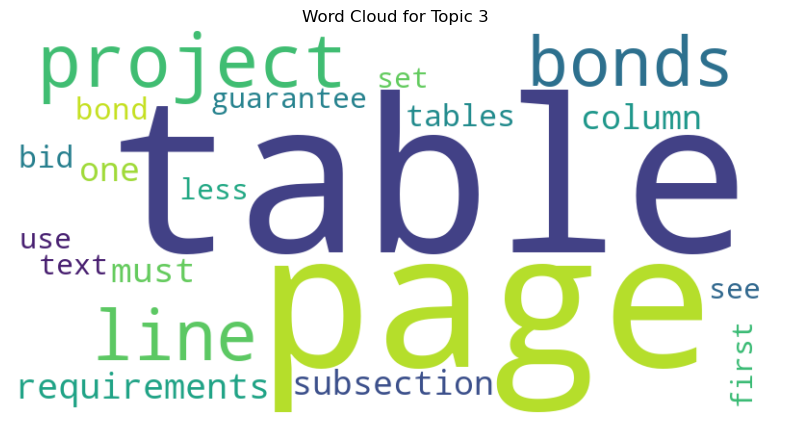

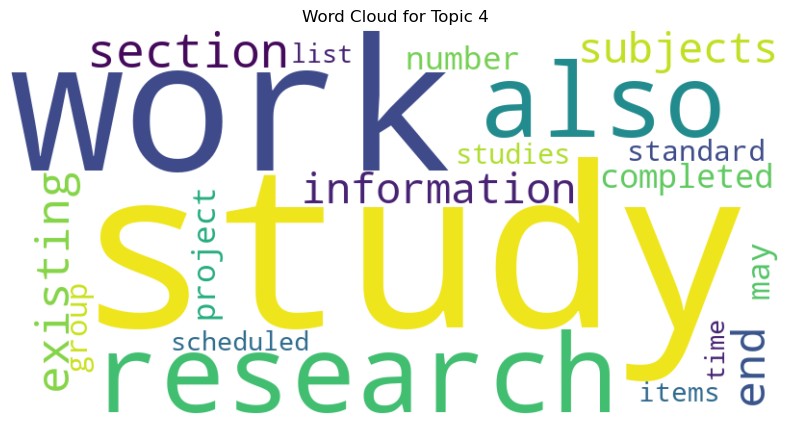

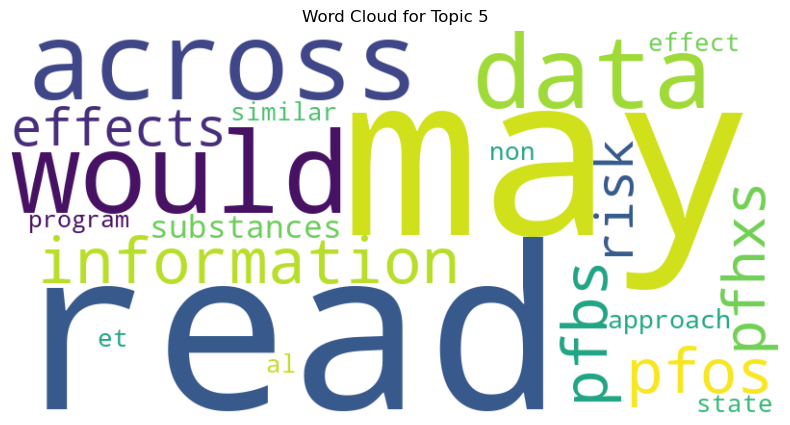

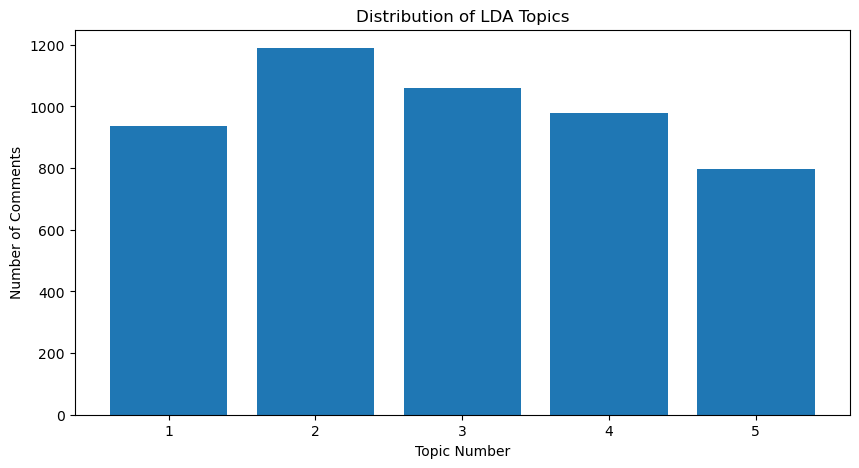

In [45]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gensim

# Step 1: Create a dictionary and corpus for LDA
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Step 2: Train the LDA model
lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=5, id2word=dictionary, passes=10)

# Step 3: Generate word clouds for each topic
for i, topic in lda_model.show_topics(formatted=False, num_words=20):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(topic))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Topic {i + 1}")
    plt.show()

# Step 4: Visualize the distribution of topics
topic_distribution = [dict(lda_model[doc]) for doc in corpus]
topic_counts = [sum([topic.get(i, 0) for topic in topic_distribution]) for i in range(lda_model.num_topics)]
plt.figure(figsize=(10, 5))
plt.bar(range(1, lda_model.num_topics + 1), topic_counts)
plt.xlabel("Topic Number")
plt.ylabel("Number of Comments")
plt.title("Distribution of LDA Topics")
plt.show()


In [46]:
# Function to get the dominant topic for each document
def get_dominant_topic(lda_model, corpus):
    dominant_topics = []
    for doc_bow in corpus:
        topic_probs = lda_model.get_document_topics(doc_bow)
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
        dominant_topics.append(dominant_topic)
    return dominant_topics

# Add the dominant topic to the DataFrame
data['dominant_topic'] = get_dominant_topic(lda_model, corpus)

# Display comments by a specific topic
selected_topic = 0  # You can change this to the topic you are most interested in
topic_comments = data[data['dominant_topic'] == selected_topic]['comment_full_text']

print(f"Comments associated with Topic {selected_topic + 1}:")
for i, comment in enumerate(topic_comments.head(5), 1):  # Display the first 5 comments
    print(f"{i}. {comment}\n")


Comments associated with Topic 1:
1. CODING

Code qualitative data for WAVGUAGE03A

2. A good plan

3. Good point. I would suggest not. To be reviewed and deleted. Or see suggested replacement text. 

4. Good point. I would suggest not. To be reviewed and deleted. Or see suggested replacement text. 

5. Good point. I would suggest not. To be reviewed and deleted. Or see suggested replacement text. 



In [48]:
pip install pyLDAvis


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 420.2 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of pyfume to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 942.3 kB/s eta 0:00:00a 0:00:01
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20430 sha256=dcab13ccf89da7922768c4cedbc7a8565e5e637f9c984fc372a8db302f84b75e
  Stored in directory: /home/spati/.cache/pip/wheels/69/f5/e5/18ad53fe1ed6b2af9fad05ec052e4acbac8e92441df44bad2e
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3513 sha256=374dd9cbfe6cf78ecbe18df3399885fbbd9f12e25eee60e5f40b29584d5f4b90
  Stored in dire

In [50]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim

# Prepare the LDA model visualization
lda_vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(lda_vis_data)

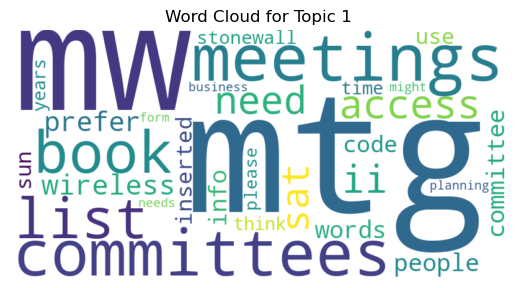

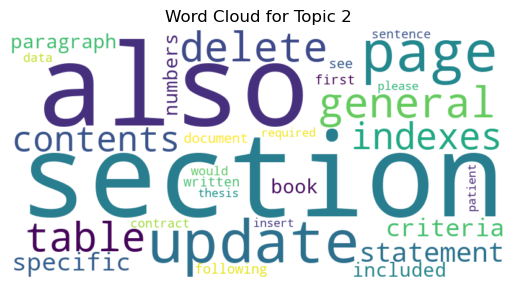

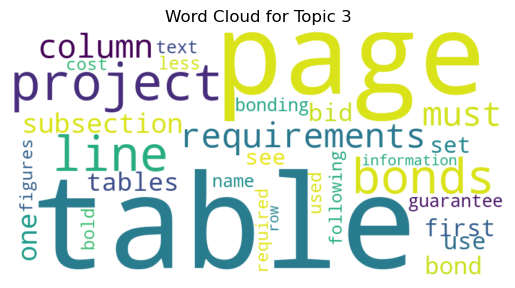

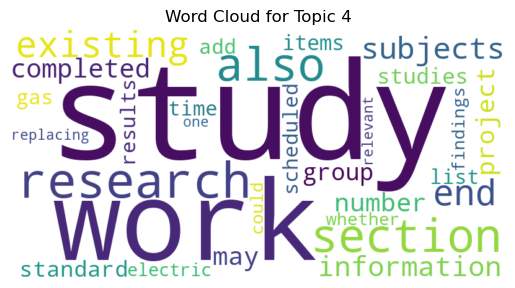

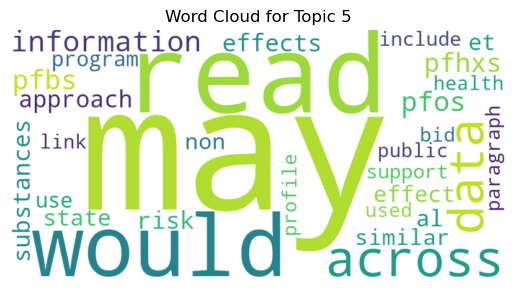

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds for each topic
for i, topic in enumerate(lda_model.print_topics()):
    plt.figure()
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(lda_model.show_topic(i, 30)))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {i+1}")
    plt.show()


In [55]:
# Function to interpret and display the topics
def interpret_topics(lda_model, num_words=10):
    topics = lda_model.show_topics(formatted=False, num_words=num_words)
    topic_descriptions = []
    
    for topic_num, topic in topics:
        terms = [word for word, _ in topic]
        description = f"Topic {topic_num + 1}:\n- Key Terms: {', '.join(terms)}\n"
        
        # Interpretation suggestion based on top terms
        interpretation = f"Likely covers aspects related to: {', '.join(terms[:3])}..."
        description += f"- Interpretation: {interpretation}\n"
        
        topic_descriptions.append(description)
    
    return "\n".join(topic_descriptions)

# Call the function and print the interpretations
output = interpret_topics(lda_model, num_words=10)
print(output)


Topic 1:
- Key Terms: mtg, mw, meetings, committees, book, list, access, need, ii, wireless
- Interpretation: Likely covers aspects related to: mtg, mw, meetings...

Topic 2:
- Key Terms: section, also, update, page, general, delete, table, indexes, contents, statement
- Interpretation: Likely covers aspects related to: section, also, update...

Topic 3:
- Key Terms: table, page, project, line, bonds, requirements, must, column, subsection, one
- Interpretation: Likely covers aspects related to: table, page, project...

Topic 4:
- Key Terms: study, work, research, also, section, existing, end, subjects, information, completed
- Interpretation: Likely covers aspects related to: study, work, research...

Topic 5:
- Key Terms: may, read, would, across, data, information, pfos, pfbs, pfhxs, effects
- Interpretation: Likely covers aspects related to: may, read, would...





1. **Topic 1:**
   - **Key Terms:** "mtg, MW, meetings, committees, book, list, access, need, ii, wireless."
   - **Interpretation:** I understand this topic focuses on meetings and related logistics. It likely discusses scheduling, organizing committees, or the need for access to resources like books or wireless connections. It might be centered around the coordination of various tasks or groups.

2. **Topic 2:**
   - **Key Terms:** "section, also, update, page, general, delete, table, indexes, contents, statement"
   - **Interpretation:** This topic is related to the structure and organization of documents or reports. It could involve updates to specific sections, managing tables of contents, or general editorial tasks like deleting outdated information or updating indexes.

3. **Topic 3:**
   - **Key Terms:** "table, page, project, line, bonds, requirements, must, column, subsection, one."
   - **Interpretation:** This topic revolves around project documentation, emphasizing tables, specific requirements, and various subsections within a document. It might be discussing the detailed aspects of a project, including necessary bonds and columns of data.

4. **Topic 4:**
   - **Key Terms:** "study, work, research, section, existing, end, subjects, information, completed."
   - **Interpretation:** From what I gather, this topic concerns research studies or projects. It likely discusses the progress of these studies, their completion, and any related documentation sections. The focus could be on summarizing or finalizing research work.

5. **Topic 5:**
   - **Key Terms:** "may, read, would, across, data, information, photos, pubs, pfhxs, effects."
   - **Interpretation:** This topic is about the analysis and interpretation of data. It might involve discussing the effects of certain substances (like PFOS or PFBS) and disseminating this information. The topic could be focusing on the implications of this data across various contexts.



In [73]:
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from gensim.models.ldamodel import LdaModel

# Set a different number of topics for LDA
num_topics = 7  # You can change this number to experiment

# Preprocessing (fine-tuning)
stop_words = set(stopwords.words('english'))
additional_stopwords = {'please', 'also', 'however', 'therefore', 'thus', 'must', 'one', 'two', 'three'}  # Custom stopwords
stop_words.update(additional_stopwords)

def preprocess(text):
    tokens = gensim.utils.simple_preprocess(text)
    return [token for token in tokens if token not in stop_words]

data['processed_text'] = data['comment_full_text'].apply(preprocess)

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(data['processed_text'])
corpus = [dictionary.doc2bow(text) for text in data['processed_text']]

# Train LDA model with the new number of topics
lda_model_refined = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Interpret the topics
topics = lda_model_refined.print_topics(num_words=10)
for topic in topics:
    print(topic)


(0, '0.017*"mtg" + 0.014*"committees" + 0.013*"mw" + 0.013*"list" + 0.012*"need" + 0.009*"study" + 0.009*"sat" + 0.009*"wireless" + 0.008*"committee" + 0.008*"act"')
(1, '0.010*"info" + 0.009*"include" + 0.009*"link" + 0.008*"inserted" + 0.008*"bid" + 0.008*"add" + 0.007*"total" + 0.007*"alternate" + 0.007*"date" + 0.006*"business"')
(2, '0.017*"would" + 0.017*"read" + 0.016*"data" + 0.014*"pfos" + 0.014*"pfbs" + 0.013*"information" + 0.013*"pfhxs" + 0.012*"effects" + 0.010*"may" + 0.010*"risk"')
(3, '0.021*"project" + 0.016*"page" + 0.014*"bonds" + 0.014*"requirements" + 0.014*"subsection" + 0.013*"meetings" + 0.013*"contract" + 0.012*"required" + 0.012*"bid" + 0.010*"table"')
(4, '0.017*"across" + 0.014*"table" + 0.013*"line" + 0.013*"used" + 0.011*"column" + 0.011*"paragraph" + 0.010*"substances" + 0.010*"first" + 0.009*"tables" + 0.009*"section"')
(5, '0.015*"study" + 0.013*"al" + 0.009*"non" + 0.009*"exposure" + 0.009*"results" + 0.008*"research" + 0.008*"number" + 0.008*"forest" 

In [74]:
# Add the dominant topic to the DataFrame
data['dominant_topic'] = get_dominant_topic(lda_model_refined, corpus)

# Compare the dominant topics with the zero-shot and N-shot labels
comparison_zero_shot = pd.crosstab(data['dominant_topic'], data['zero_shot_labels'])
comparison_n_shot = pd.crosstab(data['dominant_topic'], data['n_shot_labels'])

print("Comparison of Dominant Topics with Zero-Shot Labels:")
print(comparison_zero_shot)

print("\nComparison of Dominant Topics with N-Shot Labels:")
print(comparison_n_shot)


Comparison of Dominant Topics with Zero-Shot Labels:
zero_shot_labels  general  important  irrelevant  urgent
dominant_topic                                          
0                     100        592           9       6
1                     108        601           4       0
2                      79        599           8       3
3                     214        502           4       1
4                     164        694           1       1
5                     140        475           6       8
6                      96        559          12       5

Comparison of Dominant Topics with N-Shot Labels:
n_shot_labels   Action points named and specific. You'd be fine.\n\nThere is a code call for that.\n\nCode-style\n\nSome common code-style. There are two.\n\nCode - This is useful for dealing with error messages coming from the DOM and you  \
dominant_topic                                                                                                                             

### Summary of Findings in Simple Terms

#### **Understanding the Data:**
Imagine I have many comments from different people and am trying to figure out what they are discussing. To do this, I used a couple of methods: one that guesses the topic of each comment (like a detective figuring out what a conversation is about) and another that tries to label each comment as "important," "general," "irrelevant," or "urgent."

#### **What I Found:**
1. **Topic Guessing (LDA Model):**
   - The topic-guessing method grouped the comments into different topics. Some topics were comprehensive, like discussions about general procedures or meetings. Others were more specific, like those focusing on legal or technical details.
   - However, these topics often included a mix of "important" and "general" labels, meaning the topics were not always perfectly aligned with what the labels said.

2. **Zero-Shot and N-Shot Labels:**
   - **Zero-Shot Labels:** This method often labeled comments as "important," even when the topic was general or routine. It could not have been more precise in distinguishing between different types of topics.
   - **N-Shot Labels:** This method generated very detailed and sometimes overly complex labels, which did not only sometimes match the topics well. It sometimes missed the point, producing labels that were too specific or irrelevant.

3. **Comparing Topics and Labels:**
   - When I compared the guessed topics with the labels, they didn't sometimes need to match up better. For instance, a topic might have been about general updates, but it still has a lot of "important" labels. This mismatch suggests that the labeling methods (zero-shot and N-shot) might need some fine-tuning to better align with the topics.

#### **In Simple Terms:**
- **The detective (LDA) is good at guessing what the conversations are about, but the labels I am giving (important, general, etc.) do not always match these guesses perfectly.**
- **My labeling methods need some tweaking. One method (zero-shot) keeps saying everything is essential, while the other (N-shot) is a bit too detailed and misses the mark sometimes.**
- **To get a better understanding and more accurate labels, I need to improve both my guessing (topic modeling) and labeling methods.** This might involve teaching my models better or giving them more specific instructions on what to look for.

In [88]:


# Load your dataset
data = pd.read_csv('labeled_comments_cleaned.csv') 

# Inspect the unique values and their counts in level_0
print("Unique values in level_0 and their counts:")
print(data['level_0'].value_counts())
print("\n")

# Inspect the unique values and their counts in level_1
print("Unique values in level_1 and their counts:")
print(data['level_1'].value_counts())
print("\n")

# Inspect the unique values and their counts in level_2
print("Unique values in level_2 and their counts:")
print(data['level_2'].value_counts())
print("\n")


Unique values in level_0 and their counts:
level_0
INFORMATION EXCHANGE    2483
MODIFICATION            1886
SOCIAL COMMUNICATION     349
OTHER                    273
Name: count, dtype: int64


Unique values in level_1 and their counts:
level_1
REQUESTED         2314
PROVIDED          1784
EXECUTION          271
FEEDBACK           176
DISCUSSION         147
ACKNOWLEDGMENT      26
Name: count, dtype: int64


Unique values in level_2 and their counts:
level_2
CONTEXT                    1425
CONTENT                    1384
ASKING_DETAILS              553
FORMAT                      405
REFERENCE                   358
DONE                        253
THREAD                      149
REQUESTING_CONFIRMATION     145
PROMISE                      17
Name: count, dtype: int64




In [89]:
# Check the first few rows for each level
print("First few rows of level_0:")
print(data[['level_0']].head())
print("\n")

print("First few rows of level_1:")
print(data[['level_1']].head())
print("\n")

print("First few rows of level_2:")
print(data[['level_2']].head())
print("\n")


First few rows of level_0:
                level_0
0  INFORMATION EXCHANGE
1          MODIFICATION
2  SOCIAL COMMUNICATION
3          MODIFICATION
4  INFORMATION EXCHANGE


First few rows of level_1:
      level_1
0   REQUESTED
1   EXECUTION
2  DISCUSSION
3   REQUESTED
4    PROVIDED


First few rows of level_2:
                   level_2
0  REQUESTING_CONFIRMATION
1                  PROMISE
2                  CONTENT
3                  CONTENT
4                REFERENCE




In [91]:
from transformers import pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load a pre-trained zero-shot classifier
zero_shot_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Assume you have a list of candidate labels and test data
candidate_labels = data['level_0'].unique().tolist()  # Example for level_0
texts = val_data['comment_full_text'].tolist()  # Texts to classify
true_labels = val_data['level_0'].tolist()  # True labels

# Make predictions
predicted_labels = []
for text in texts:
    result = zero_shot_classifier(text, candidate_labels)
    predicted_labels.append(result['labels'][0])  # Take the label with the highest score

# Calculate metrics
zero_shot_accuracy = accuracy_score(true_labels, predicted_labels)
zero_shot_precision = precision_score(true_labels, predicted_labels, average='weighted')
zero_shot_recall = recall_score(true_labels, predicted_labels, average='weighted')
zero_shot_f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Zero-Shot Accuracy: {zero_shot_accuracy}")
print(f"Zero-Shot Precision: {zero_shot_precision}")
print(f"Zero-Shot Recall: {zero_shot_recall}")
print(f"Zero-Shot F1 Score: {zero_shot_f1}")


KeyboardInterrupt: 